# Evaluation of experiment

Evaluates the results that come from one experiment


To reproduce run experiments/experiment_3_sequence_length/hpc_training.sh

## Experiment 3 Sequence length

In [1]:
# specify EXPERIMENT_NAME - has to correspond to experiments/EXPERIMENT_NAME and models/EXPERIMENT_NAME
experiment_name = "experiment_3_sequence_length"


In [2]:
#change cwd but save path to notebook to save figures
import os
if not 'src' in os.listdir():
    base_dir_notebook = os.path.abspath(".")
    os.chdir("../..")
import pandas as pd
import yaml
import numpy as np
from src.models.utils import load_model, get_best_model_path, get_loss, TrainedModels
from torch.utils.data import DataLoader
from src.data.synthetic_dataset import SyntheticDataset
from scipy.stats import wilcoxon
import pytorch_lightning as pl
import seaborn as sns
import matplotlib.pyplot as plt
from src.visualization.visualize import TrainValidationLossVisualization, Visualization, InferenceTimeVisualization
import optuna
from src.visualization.utils import FAU_BLUE, FAU_GREY, TURQUOIS
import matplotlib.patches as patches

model_names = ["Transformer", "CNN", "LSTM"]
palette = [FAU_BLUE, FAU_GREY, TURQUOIS] # color palette for seaborn
palette_bp = [(98/256, 114/256, 136/256), FAU_GREY, TURQUOIS] # better color palette for boxplots


models_path = f"models/{experiment_name}"
test_dataset_path = f"./experiments/{experiment_name}/data/test.pkl"

trained_models = TrainedModels(models_path=models_path)

# figure path
if not os.path.exists(f"./experiments/{experiment_name}/figures"):
    os.makedirs(f"./experiments/{experiment_name}/figures")

2021-11-11 00:18:39 Mischa-PC src.models[12604] INFO Initializing Lightning model without test dataset
2021-11-11 00:18:39 Mischa-PC src.data[12604] INFO Loading dataset from ./experiments/experiment_3_sequence_length/data/train.pkl
2021-11-11 00:18:39 Mischa-PC src.data[12604] INFO Loading dataset from ./experiments/experiment_3_sequence_length/data/val.pkl
2021-11-11 00:18:39 Mischa-PC src.data[12604] INFO Shuffling dataset
2021-11-11 00:18:39 Mischa-PC src.data[12604] INFO Initializing and fitting new scaler to dataset
2021-11-11 00:18:39 Mischa-PC src.data[12604] INFO Using provided scaler to normalize dataset
2021-11-11 00:18:41 Mischa-PC src.models[12604] INFO Training size: 9984, Validation size: 1984
2021-11-11 00:18:41 Mischa-PC src.models[12604] INFO Transformer complexity: 10737418240
2021-11-11 00:18:41 Mischa-PC src.models[12604] INFO Provided path successfully loaded Model of type: <class 'src.models.lightning_models.Transformer'>
2021-11-11 00:18:41 Mischa-PC src.models[

In [3]:
print([x["path"] for x in trained_models])

['/experiments/experiment_3_sequence_length/data/train.pkl-epoch=95-val_loss=0.0392.ckpt', '/experiments/experiment_3_sequence_length/data/train.pkl-epoch=99-val_loss=0.0389.ckpt', '/experiments/experiment_3_sequence_length/data/train.pkl-epoch=99-val_loss=0.0317.ckpt']


# Visualize train/validation loss

2021-11-11 00:18:42 Mischa-PC src.visualization[12604] INFO using latex font


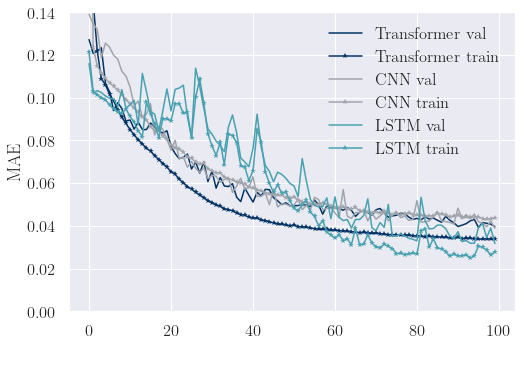

In [4]:
#load val/train loss
epoch = []
values = []
for model in trained_models:
    epoch.append(np.arange(len(model["val_loss"])))
    epoch.append(np.arange(len(model["train_loss"])))
    values.append(model["val_loss"])
    values.append(model["train_loss"])

# prepare style of plot
linestyle = ["-", "-","-", "-","-", "-",]
labels = ["Transformer val", "Transformer train", "CNN val", "CNN train", "LSTM val", "LSTM train"]
markers = ["", "*", "", "*", "", "*"]

# plot train and validaton loss and save figure
viz = TrainValidationLossVisualization(use_latex_font=True, font_scale=1.5)
viz.subplots(1, 1)
viz.plot(steps=epoch, val_losses=values, labels=labels, linestyles=linestyle, markers=markers, xlabel="Epochs", ylabel="MAE")
plt.xlabel("EpochsOl", color='#ffffff')
plt.legend()
plt.grid()
plt.ylim(0, 0.14)
plt.savefig(f"{base_dir_notebook}/figures/train_and_val_loss_all_models.pdf")
plt.show()

# Validation Loss only

2021-11-11 00:18:46 Mischa-PC src.visualization[12604] INFO using latex font


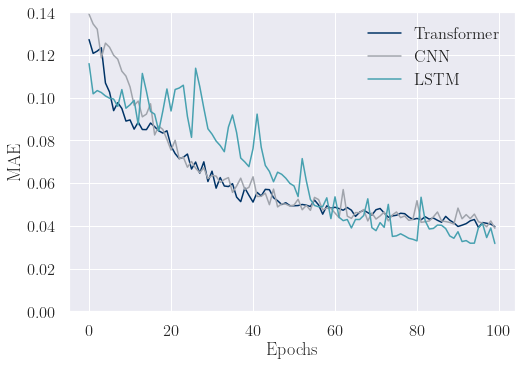

In [5]:
epoch = []
values = []
for model in trained_models:
    epoch.append(np.arange(len(model["val_loss"])))
    values.append(model["val_loss"])

linestyle = ["-","-","-"]
labels = ["Transformer", "CNN", "LSTM"]
markers = ["", "", ""]
colors = [FAU_BLUE, FAU_GREY, TURQUOIS]

# plot train and validaton loss and save figure
viz = TrainValidationLossVisualization(use_latex_font=True, font_scale=1.5)
viz.subplots(1, 1)
viz.plot(steps=epoch, val_losses=values, labels=labels, linestyles=linestyle, markers=markers, colors=colors, xlabel="Epochs", ylabel="MAE")
plt.legend()
plt.grid()
plt.ylim(0, 0.14)
plt.savefig(f"{base_dir_notebook}/figures/validation_loss_all_models.pdf")
plt.show()

## Save the performance of every model on every test sample seperately
First load data, normalized i based on training data and then perform test

In [6]:
test_dataloader = DataLoader(SyntheticDataset.load(test_dataset_path),
                                 batch_size=4)
if not test_dataloader.dataset.is_normalized:
    test_dataloader.dataset.normalize(scaler=trained_models["transformer"]["model"].train_dataset.scaler)

2021-11-11 00:18:47 Mischa-PC src.data[12604] INFO Loading dataset from ./experiments/experiment_3_sequence_length/data/test.pkl
2021-11-11 00:18:47 Mischa-PC src.data[12604] INFO Using provided scaler to normalize dataset


## Transformer

In [7]:
tf_trainer = pl.Trainer(gpus=1, logger=None)
tf_trainer.test(model=trained_models["transformer"]["model"], test_dataloaders=test_dataloader)
transformer_predictions = pd.DataFrame(tf_trainer.lightning_module.evaluated_samples)

2021-11-11 00:18:47 Mischa-PC pytorch_lightning.utilities.distributed[12604] INFO GPU available: True, used: True
2021-11-11 00:18:47 Mischa-PC pytorch_lightning.utilities.distributed[12604] INFO TPU available: False, using: 0 TPU cores
2021-11-11 00:18:47 Mischa-PC pytorch_lightning.utilities.distributed[12604] INFO IPU available: False, using: 0 IPUs
C:\Users\Mischa\Anaconda3\envs\mtenv\lib\site-packages\pytorch_lightning\trainer\trainer.py:678: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
2021-11-11 00:18:47 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Mischa\Anaconda3\envs\mtenv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_work

Testing: 0it [00:00, ?it/s]

C:\Users\Mischa\Anaconda3\envs\mtenv\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mae': 0.04884457215666771, 'test_mse': 0.006274363957345486}
--------------------------------------------------------------------------------


## CNN

In [8]:
cnn_trainer = pl.Trainer(gpus=1, logger=None)
cnn_trainer.test(model=trained_models["cnn"]["model"], test_dataloaders=test_dataloader)
cnn_predictions = pd.DataFrame(cnn_trainer.lightning_module.evaluated_samples)

2021-11-11 00:19:00 Mischa-PC pytorch_lightning.utilities.distributed[12604] INFO GPU available: True, used: True
2021-11-11 00:19:00 Mischa-PC pytorch_lightning.utilities.distributed[12604] INFO TPU available: False, using: 0 TPU cores
2021-11-11 00:19:00 Mischa-PC pytorch_lightning.utilities.distributed[12604] INFO IPU available: False, using: 0 IPUs
2021-11-11 00:19:00 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mae': 0.044246044009923935, 'test_mse': 0.004482574760913849}
--------------------------------------------------------------------------------


## LSTM

In [9]:
lstm_trainer = pl.Trainer(gpus=1, logger=None)
lstm_trainer.test(model=trained_models["lstm"]["model"], test_dataloaders=test_dataloader)
lstm_predictions = pd.DataFrame(lstm_trainer.lightning_module.evaluated_samples)

2021-11-11 00:19:07 Mischa-PC pytorch_lightning.utilities.distributed[12604] INFO GPU available: True, used: True
2021-11-11 00:19:07 Mischa-PC pytorch_lightning.utilities.distributed[12604] INFO TPU available: False, using: 0 TPU cores
2021-11-11 00:19:07 Mischa-PC pytorch_lightning.utilities.distributed[12604] INFO IPU available: False, using: 0 IPUs
2021-11-11 00:19:07 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mae': 0.03378422558307648, 'test_mse': 0.003460558131337166}
--------------------------------------------------------------------------------


## Mean Estimator baseline
Mae of estimator that uses mean of input as output prediction:

In [10]:
from torch.nn import L1Loss
loss = L1Loss()

mae = 0
count = 0
for x, y, chars in trained_models["transformer"]["model"].val_dataset: #test_dataloader:
    # reshape s.t. shape == (batch_num, sample_sequence_length //2)
    y = y.transpose(0, 1) if len(y.shape) == 2 else y.reshape(-1, y.shape[1])
    x = x.transpose(0, 1) if len(x.shape) == 2 else x.reshape(-1, x.shape[1])
    means = x.mean(axis=(1)).reshape(y.shape[0], 1)
    preds = means.tile((1, y.shape[1] ))
    mae += loss(preds, y)
    count += 1
mean_predictor_mae= mae/count
print(mean_predictor_mae)

tensor(0.1091)


## Visualizations

### Start of by creating a dataframe with all the Predictions

In [11]:
transformer_predictions["model"] = "Transformer"
transformer_predictions["sample_idx"] = np.arange(len(transformer_predictions))

cnn_predictions["model"] = "CNN"
cnn_predictions["sample_idx"] = np.arange(len(cnn_predictions))

lstm_predictions["model"] = "LSTM"
lstm_predictions["sample_idx"] = np.arange(len(lstm_predictions))

frames = [transformer_predictions, cnn_predictions, lstm_predictions]
predictions = pd.concat(frames)
predictions.head()

,d,l,s,f,a1,a2,a3,mean,mae,mse,model,sample_idx
0,0.0,128.0,2.0,0.0625,1.0,-13.0,-49.0,66,0.019097,0.000491,Transformer,0
1,0.0,128.0,2.0,0.0625,-28.0,21.0,-39.0,66,0.029794,0.001342,Transformer,1
2,0.0,128.0,2.0,0.0625,27.0,-55.0,-40.0,62,0.024261,0.001143,Transformer,2
3,0.0,128.0,2.0,0.0625,49.0,-4.0,29.0,59,0.037340,0.002452,Transformer,3
4,0.0,128.0,2.0,0.0625,-18.0,28.0,11.0,76,0.018774,0.000539,Transformer,4


# Visualize distribution of mae for different delay lengths

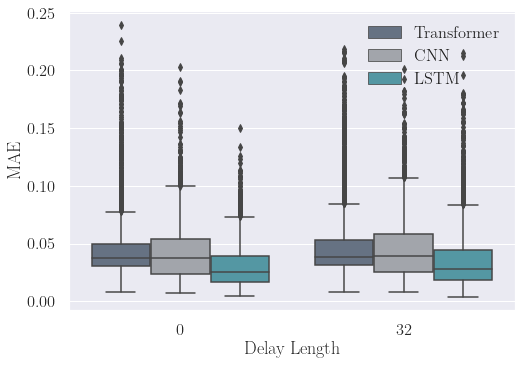

In [12]:
sns.boxplot(x="d", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.ylabel("MAE")
delays = predictions["d"].unique()
plt.xticks(ticks=np.arange(len(delays)), labels=[int(x) for x in delays])
plt.xlabel("Delay Length")
plt.legend().title = None # disables legend title which is 'model'
plt.savefig(base_dir_notebook + "/figures/mae_different_frequencies.pdf")

# Visualize distribution of mae for different frequencies

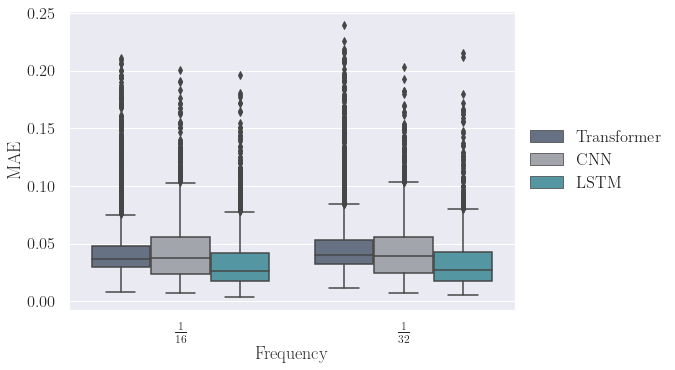

In [13]:
sns.boxplot(x="f", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.ylabel("MAE")
freqs = predictions["f"].unique()
nice_labels = {1/128:r"$\frac{1}{128}$", 1/64:r"$\frac{1}{64}$", 1/32:r"$\frac{1}{32}$", 1/16:r"$\frac{1}{16}$", 1/8:r"$\frac{1}{8}$"}
plt.xticks(ticks=np.arange(len(freqs)), labels=[nice_labels[f] for f in freqs])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.xlabel("Frequency")
plt.savefig(base_dir_notebook + "/figures/mae_different_frequencies.pdf")

# Visualize distribution of mae for different sigmas

2021-11-11 00:19:38 Mischa-PC src.visualization[12604] INFO using latex font


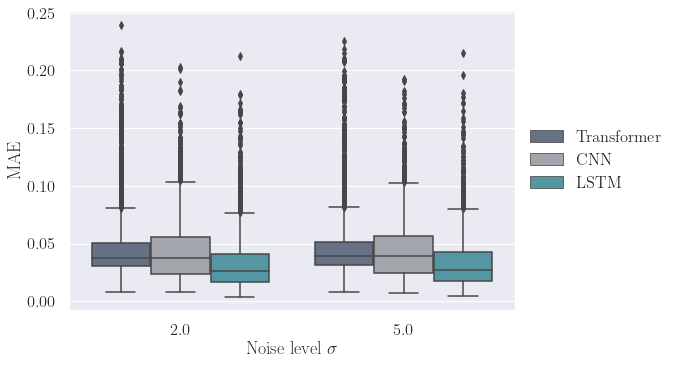

In [14]:
from src.visualization.visualize import Visualization
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
sns.boxplot(x="s", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.ylabel("MAE")
plt.xlabel("Noise level $\sigma$")
plt.savefig(base_dir_notebook + "/figures/mae_different_noise_levels.pdf")

# Visualize distribution of mae for different sequence lengths

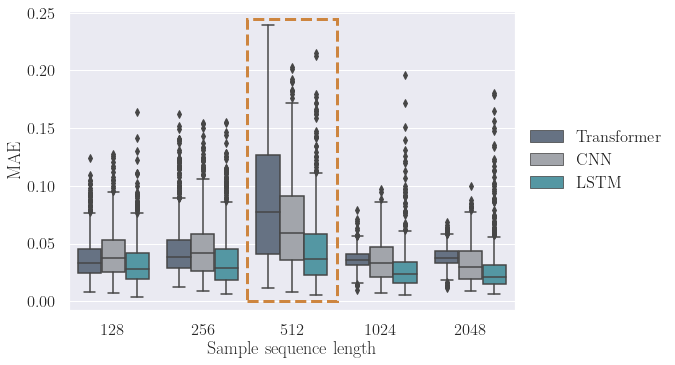

In [15]:
ax = sns.boxplot(x="l", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.ylabel("MAE")
seq_lens = predictions["l"].unique()
rect = patches.Rectangle((1.5, 0), 1, 0.245, linewidth=3, edgecolor="peru", linestyle="--", facecolor='none')
ax.add_patch(rect)
plt.xticks(ticks=np.arange(len(seq_lens)), labels=[int(x) for x in seq_lens])
plt.xlabel("Sample sequence length")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.savefig(base_dir_notebook + "/figures/mae_different_seqlens.pdf", bbox_inches="tight")

# Visualize distribution of MAEs for different Noise Levels

## Same visualization but this time with mean

2021-11-11 00:19:39 Mischa-PC src.visualization[12604] INFO using latex font


Transformer:
f:   0 lower: 0.037 - median: 0.038 - upper: 0.039
f:  32 lower: 0.038 - median: 0.039 - upper: 0.039
CNN:
f:   0 lower: 0.036 - median: 0.037 - upper: 0.039
f:  32 lower: 0.038 - median: 0.039 - upper: 0.041
LSTM:
f:   0 lower: 0.024 - median: 0.025 - upper: 0.026
f:  32 lower: 0.027 - median: 0.028 - upper: 0.029


<Figure size 576x396 with 0 Axes>

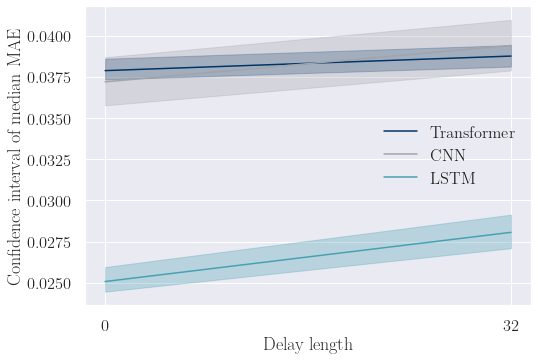

In [16]:
from src.visualization.visualize import ConfidenceIntervalVisualization

plt.clf()
viz = ConfidenceIntervalVisualization(use_latex_font=True, font_scale=1.5)
viz.subplots(1, 1)
viz.plot(predictions=predictions, characteristic="d", xlabel="Delay length", ylabel="Confidence interval of median MAE", colors=palette, verbose=True, plot_only_median=False)
plt.legend()
xticks = predictions["d"].unique()
plt.xticks(xticks, labels=[int(xt) for xt in xticks])
plt.savefig(base_dir_notebook + "/figures/confidence_intervals_delays.pdf")
plt.show()


## Bin amplitudes into categories to visualize performance change of different amplitudes

In [17]:
bin_boundaries = np.linspace(-60, 60, 13)
bins = np.linspace(-55, 55, 12)
for i in range(len(bin_boundaries) - 1):
    predictions.loc[(predictions["a1"] >= bin_boundaries[i]) & (predictions["a1"] < bin_boundaries[i + 1]), "a1_bin"] = bins[i]
    predictions.loc[(predictions["a2"] >= bin_boundaries[i]) & (predictions["a2"] < bin_boundaries[i + 1]), "a2_bin"] = bins[i]
predictions.loc[predictions["a1"] == 60, "a1_bin"] = bins[-1]
predictions.loc[predictions["a2"] == 60, "a2_bin"] = bins[-1]


2021-11-11 00:19:40 Mischa-PC src.visualization[12604] INFO using latex font


Transformer:
f: -55 lower: 0.031 - median: 0.045 - upper: 0.048
f: -45 lower: 0.028 - median: 0.031 - upper: 0.041
f: -35 lower: 0.027 - median: 0.036 - upper: 0.053
f: -25 lower: 0.035 - median: 0.041 - upper: 0.051
f: -15 lower: 0.039 - median: 0.053 - upper: 0.055
f:  -5 lower: 0.050 - median: 0.056 - upper: 0.079
f:   5 lower: 0.050 - median: 0.053 - upper: 0.111
f:  15 lower: 0.044 - median: 0.047 - upper: 0.153
f:  25 lower: 0.044 - median: 0.049 - upper: 0.056
f:  35 lower: 0.041 - median: 0.046 - upper: 0.052
f:  45 lower: 0.035 - median: 0.040 - upper: 0.053
f:  55 lower: 0.029 - median: 0.033 - upper: 0.039
CNN:
f: -55 lower: 0.046 - median: 0.052 - upper: 0.064
f: -45 lower: 0.039 - median: 0.042 - upper: 0.050
f: -35 lower: 0.044 - median: 0.046 - upper: 0.061
f: -25 lower: 0.040 - median: 0.044 - upper: 0.051
f: -15 lower: 0.051 - median: 0.055 - upper: 0.064
f:  -5 lower: 0.062 - median: 0.070 - upper: 0.081
f:   5 lower: 0.065 - median: 0.071 - upper: 0.083
f:  15 lower:

<Figure size 576x396 with 0 Axes>

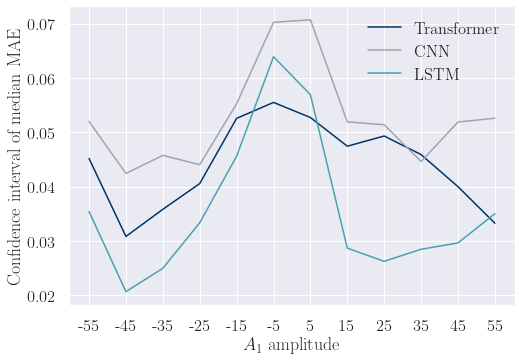

In [18]:
from src.visualization.visualize import ConfidenceIntervalVisualization

plt.clf()
viz = ConfidenceIntervalVisualization(use_latex_font=True, font_scale=1.5)
viz.subplots(1, 1)
filtered_predictions = predictions[predictions["a2_bin"] == -55]
viz.plot(predictions=filtered_predictions, characteristic="a1_bin", xlabel="$A_1$ amplitude", ylabel="Confidence interval of median MAE", colors=palette, verbose=True, plot_only_median=True)
plt.legend()
xticks = filtered_predictions["a1_bin"].unique()
plt.xticks(xticks, labels=[int(xt) for xt in xticks])
plt.savefig(base_dir_notebook + "/figures/confidence_intervals_ampltidues_a2_minus55.pdf")
plt.show()


# Visualize distribution of amplitude

2021-11-11 00:19:41 Mischa-PC src.visualization[12604] INFO using latex font


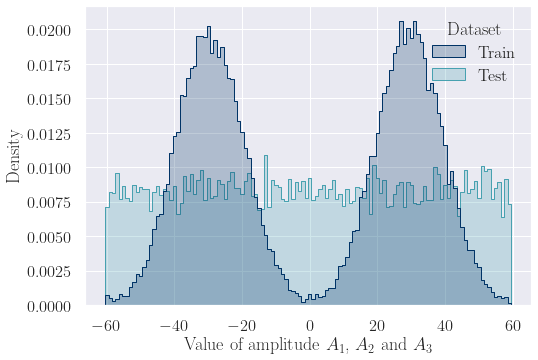

In [19]:
train_amplitudes = trained_models["transformer"]["model"].train_dataset._amplitudes[:,:3].reshape(-1) # same as model cnn and lstm
test_amplitudes = test_dataloader.dataset._amplitudes[:,:3].reshape(-1)
dataset_indicator = np.zeros(len(train_amplitudes) + len(test_amplitudes))
dataset_indicator[len(train_amplitudes):] = 1
amplitude_df = pd.DataFrame({'amplitude':np.concatenate((train_amplitudes, test_amplitudes)), 'Dataset': ["Train"] * len(train_amplitudes) + ["Test"]* len(test_amplitudes)})
bins=np.arange(train_amplitudes.min(), train_amplitudes.max()+1)-0.5

viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
sns.histplot(ax=axs[0, 0], data=amplitude_df, x="amplitude", hue="Dataset", palette=[palette[0], palette[2]], bins=bins, element='step', stat="density", common_norm=False)
plt.xlabel("Value of amplitude $A_1$, $A_2$ and $A_3$")
plt.legend
plt.savefig(base_dir_notebook + "/figures/train_test_data_distribution.pdf")
plt.show()


# Visualize Difference of model performance depending on the Delay Length

2021-11-11 00:19:42 Mischa-PC src.visualization[12604] INFO using latex font


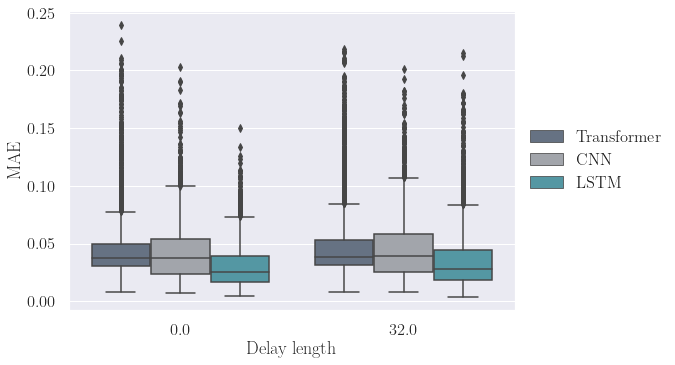

In [20]:
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
sns.boxplot(x="d", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.ylabel("MAE")
plt.xlabel("Delay length")
plt.savefig(base_dir_notebook + "/figures/mae_different_delays_all_models.pdf")


## Visualize the accuracy depending on the amplitude

2021-11-11 00:19:43 Mischa-PC src.visualization[12604] INFO using latex font


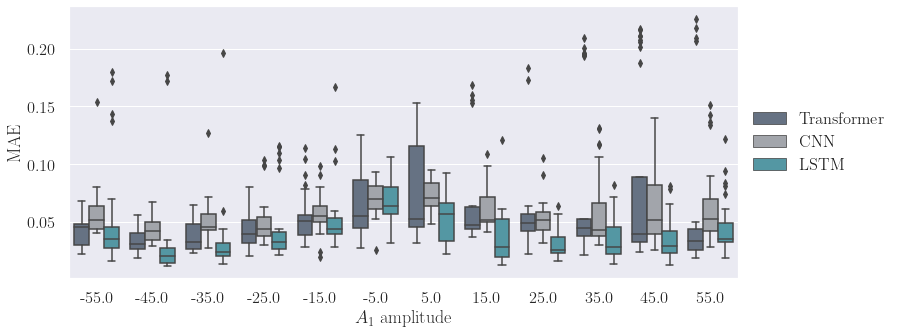

In [21]:
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1, figsize=(12, 5))
sns.boxplot(x="a1_bin", y="mae", hue="model", data=predictions[predictions["a2_bin"] == -55], palette=palette_bp)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.ylabel("MAE")
plt.xlabel("$A_1$ amplitude")
plt.savefig(base_dir_notebook + "/figures/mae_different_a1_bins_a2_bin_minus55.pdf")


## Visualize mean in 2d depending on the amplitudes

In [22]:
#model = "Transformer"
model = "Transformer"

a1_bins = sorted(predictions["a1_bin"].unique())
a2_bins = sorted(predictions["a2_bin"].unique())
means_trafo = np.zeros((len(a1_bins), len(a2_bins)))
means_cnn = np.zeros((len(a1_bins), len(a2_bins)))
means_lstm = np.zeros((len(a1_bins), len(a2_bins)))
for i, a1 in enumerate(a1_bins):
    for j, a2 in enumerate(a2_bins):
        means_trafo[i, j] = predictions[(predictions["a1_bin"] == a1) & (predictions["a2_bin"] == a2) & (predictions["model"] == "Transformer")]["mae"].mean()
        means_cnn[i, j] = predictions[(predictions["a1_bin"] == a1) & (predictions["a2_bin"] == a2) & (predictions["model"] == "CNN")]["mae"].mean()
        means_lstm[i, j] = predictions[(predictions["a1_bin"] == a1) & (predictions["a2_bin"] == a2) & (predictions["model"] == "LSTM")]["mae"].mean()

means_min = min(means_trafo.min(), means_lstm.min(), means_cnn.min())
means_max = min(means_trafo.max(), means_lstm.max(), means_cnn.max())

2021-11-11 00:19:45 Mischa-PC src.visualization[12604] INFO using latex font


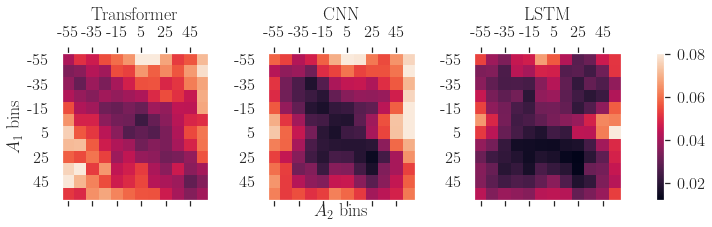

In [23]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
#https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axes = viz.subplots(1, 3, figsize=(11,  3))
fig.tight_layout(pad=1.0)
normalizer=Normalize(means_min, means_max)
im=cm.ScalarMappable(norm=normalizer)
ims = []
for i, means in enumerate([means_trafo, means_cnn, means_lstm]):
    ax = viz.get_ax(i)
    ims.append(ax.matshow(means, norm=normalizer))
    ax.grid(False)
    ax.set_title(model_names[i])
    ax.set_xticks(np.arange(len(a2_bins))[::2])
    ax.set_yticks(np.arange(len(a1_bins))[::2])
    ax.set_xticklabels(np.array(a2_bins, dtype=int)[::2])
    ax.set_yticklabels(np.array(a1_bins, dtype=int)[::2])

viz.get_ax(0).set_ylabel("$A_1$ bins")
viz.get_ax(1).set_xlabel("$A_2$ bins")

fig.colorbar(im, ax=axes.ravel().tolist())
plt.savefig(base_dir_notebook + "/figures/mae_amplitudes_all_models_matshow.pdf", bbox_inches="tight")
plt.show()


# Look at some of the best / worst predictions of Transformer

## Start with worst predictions

C:\Users\Mischa\AppData\Local\Temp/ipykernel_12604/4264748142.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  transformer_outputs = np.array(tf_trainer.lightning_module.output_predictions)
C:\Users\Mischa\AppData\Local\Temp/ipykernel_12604/4264748142.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cnn_outputs = np.array(cnn_trainer.lightning_module.output_predictions)
C:\Users\Mischa\AppData\Local\Temp/ipykernel_12604/4264748142.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of list

         d      l    s       f    a1    a2    a3  mean       mae       mse  \
1700  32.0  512.0  2.0  0.0625  47.0 -60.0   9.0    67  0.217228  0.094246   
2142  32.0  512.0  5.0  0.0625  51.0 -58.0  60.0    58  0.218247  0.094796   
2047   0.0  512.0  5.0  0.0625  59.0 -58.0 -40.0    76  0.225910  0.104043   
1658   0.0  512.0  2.0  0.0625 -59.0  59.0  40.0    67  0.239557  0.106209   

            model  sample_idx  a1_bin  a2_bin  
1700  Transformer        1700    45.0   -55.0  
2142  Transformer        2142    55.0   -55.0  
2047  Transformer        2047    55.0   -55.0  
1658  Transformer        1658   -55.0    55.0  


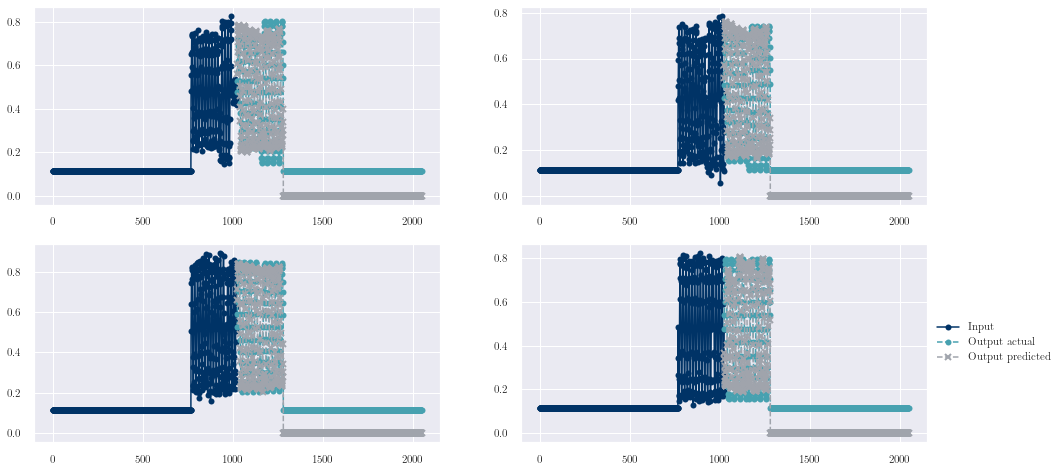

In [24]:
from src.visualization.visualize import ModelPredictionVisualization
transformer_outputs = np.array(tf_trainer.lightning_module.output_predictions)
cnn_outputs = np.array(cnn_trainer.lightning_module.output_predictions)
lstm_outputs  = np.array(lstm_trainer.lightning_module.output_predictions)
outputs = {"CNN": cnn_outputs,
           "Transformer": transformer_outputs,
           "LSTM":lstm_outputs}


viz_num = 4
# get the worst samples with delay length 48 and visualize them
samples = predictions.sort_values(by="mae")

best_samples = samples[:viz_num]
median_samples = samples[(len(samples) // 2):(len(samples) // 2 + viz_num)]
worst_samples = samples[-viz_num:]

# ground truth
worst_x, worst_y, _ = test_dataloader.dataset[worst_samples["sample_idx"]]
median_x, median_y, _ = test_dataloader.dataset[median_samples["sample_idx"]]
best_x, best_y, _ = test_dataloader.dataset[best_samples["sample_idx"]]

# predicted
out_preds = []
pred_start = len(worst_x[0])
print(worst_samples.head(viz_num))
for idx, model in zip(worst_samples["sample_idx"], worst_samples["model"]):
    out_preds.append(outputs[model][idx])

# Visualize
use_latex_font = False
viz = ModelPredictionVisualization(use_latex_font=False)
viz.subplots(nrows=viz_num // 2, ncols=2, figsize=(16, 8))
viz.plot(worst_x, worst_y, out_preds, pred_starts=[pred_start, ] * viz_num)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
viz.save(filename=base_dir_notebook+ "/figures/worst_samples.pdf")
viz.plt.show()


Remark: Padded points are not added to the loss calculation so its not problem that the normalization made zero
slightly higher (only looks odd in visualization)
# Median Sample

           mae        model     d       l    s        f    a1    a2
913   0.035068          CNN  32.0   256.0  2.0  0.06250  -7.0  25.0
871   0.035070  Transformer   0.0   256.0  2.0  0.06250 -41.0  41.0
3171  0.035078  Transformer  32.0  1024.0  5.0  0.03125  -9.0  39.0
2518  0.035079         LSTM  32.0  1024.0  2.0  0.06250  37.0 -49.0


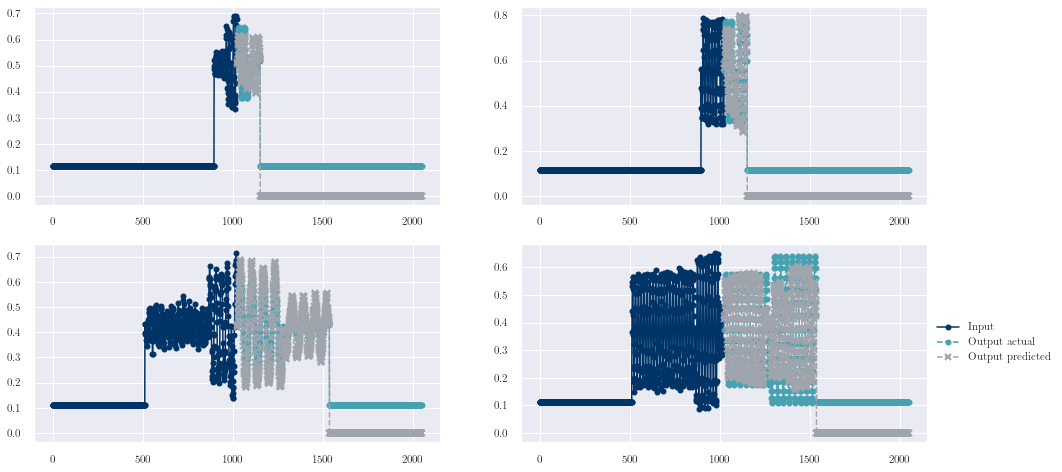

In [25]:
out_preds = []

print(median_samples[["mae", "model", "d","l","s","f","a1","a2"]])
for idx, model in zip(median_samples["sample_idx"], median_samples["model"]):
    out_preds.append(outputs[model][idx])

# Visualize
use_latex_font = False
viz = ModelPredictionVisualization(use_latex_font=False)
viz.subplots(nrows=viz_num // 2, ncols=2, figsize=(16, 8))
viz.plot(median_x, median_y, out_preds, pred_starts=[pred_start, ] * viz_num)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
viz.save(filename=base_dir_notebook+ "/figures/median_samples.pdf")
viz.plt.show()

## Best predictions

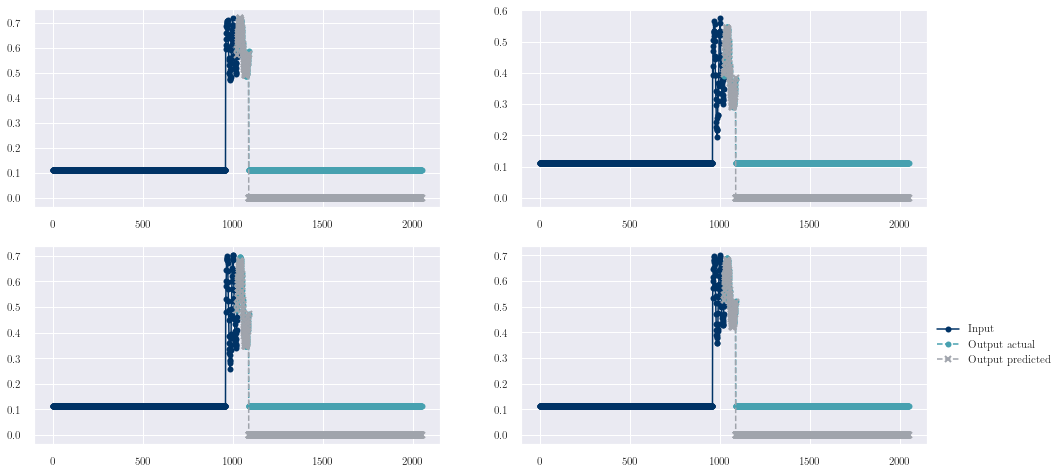

In [26]:
out_preds = []

for idx, model in zip(best_samples["sample_idx"], best_samples["model"]):
    out_preds.append(outputs[model][idx])

trafo_out_pred = cnn_outputs[best_samples["sample_idx"]]
# Visualize
use_latex_font = False
viz = ModelPredictionVisualization(use_latex_font=False)
viz.subplots(nrows=viz_num // 2, ncols=2, figsize=(16, 8))
viz.plot(best_x, best_y, out_preds, pred_starts=[pred_start, ] * viz_num)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
viz.save(filename=base_dir_notebook+ "/figures/worst_samples.pdf")
viz.plt.show()

## Median predictions with length 2048

        d       l    s        f    a1    a2    a3  mean       mae       mse  \
3472  0.0  2048.0  2.0  0.03125 -43.0 -19.0 -35.0    74  0.032001  0.001456   
3838  0.0  2048.0  5.0  0.03125  -4.0 -24.0 -55.0    90  0.032024  0.001407   
3633  0.0  2048.0  5.0  0.06250 -49.0 -12.0  56.0    60  0.032024  0.001611   
3836  0.0  2048.0  5.0  0.03125  44.0  39.0 -13.0    47  0.032044  0.001590   

            model  sample_idx  a1_bin  a2_bin  
3472          CNN        3472   -45.0   -15.0  
3838  Transformer        3838    -5.0   -25.0  
3633         LSTM        3633   -45.0   -15.0  
3836  Transformer        3836    45.0    35.0  


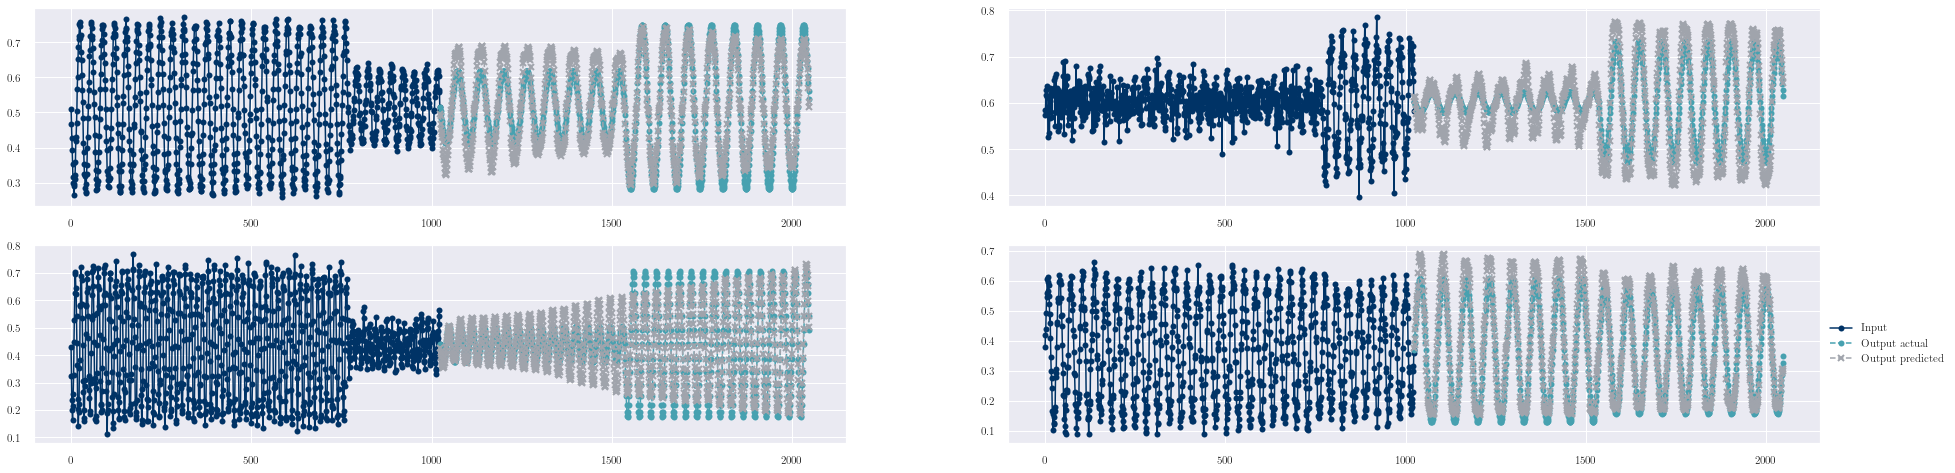

In [27]:
# choose sample to be median of all samples with l = 2048
long_samples  = samples[samples["l"] == 2048]
median_samples = long_samples[len(long_samples)//2:len(long_samples) // 2 + viz_num]

# ground truth
median_x, median_y, _ = test_dataloader.dataset[median_samples["sample_idx"]]

# predicted
out_preds = []
pred_start = len(median_x[0])
for idx, model in zip(median_samples["sample_idx"], median_samples["model"]):
    out_preds.append(outputs[model][idx])
print(median_samples.head(viz_num))

# Visualize
use_latex_font = False
viz = ModelPredictionVisualization(use_latex_font=False)
viz.subplots(nrows=viz_num // 2, ncols=2, figsize=(32, 8))
viz.plot(median_x, median_y, out_preds, pred_starts=[pred_start, ] * viz_num)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
viz.save(filename=base_dir_notebook+ "/figures/median_with_maximum_length.pdf")
viz.plt.show()

## Best prediction on generalized sequence length

In [28]:
# choose sample to be median of all samples with l = 2048
long_samples  = samples[samples["l"] == 512]
print(long_samples.head())
best_sample = long_samples[0:1]

# ground truth
best_x, best_y, chars = test_dataloader.dataset[best_sample["sample_idx"]]
assert best_x.shape[1] == 1024
best_x_cut = best_x.reshape(-1)[-256:] # cut off zero padded
best_y_cut = best_y.reshape(-1)[:256]

# predicted
out_preds = []
for idx, model in zip(best_sample["sample_idx"], best_sample["model"]):
    out_preds.append(outputs[model][idx].reshape(-1)[:256])

         d      l    s        f    a1    a2    a3  mean       mae       mse  \
1925  32.0  512.0  2.0  0.03125  18.0  12.0  25.0    58  0.005776  0.000049   
2085   0.0  512.0  5.0  0.06250   9.0  14.0  44.0    75  0.006653  0.000069   
1897   0.0  512.0  2.0  0.03125  28.0  18.0  49.0    81  0.007452  0.000092   
2258   0.0  512.0  5.0  0.03125  15.0   9.0   3.0    62  0.007580  0.000091   
2356  32.0  512.0  5.0  0.03125  25.0  15.0  44.0    76  0.007585  0.000093   

     model  sample_idx  a1_bin  a2_bin  
1925  LSTM        1925    15.0    15.0  
2085  LSTM        2085     5.0    15.0  
1897  LSTM        1897    25.0    15.0  
2258  LSTM        2258    15.0     5.0  
2356  LSTM        2356    25.0    15.0  


In [29]:
period_length = int(1 / chars[0][0][0])
sigma = int(chars[0][0][3])
a1 = int(chars[2][0][0])
a2 = int(chars[2][0][1])
a3 = int(chars[2][0][2])
description = f"f = $\\frac{{1}}{{{period_length}}}$, d = ${int(chars[0][0][1])}$, $\sigma = {sigma}$, $A_1 = {a1}, A_2 = {a2}, A_3 = {a3}$, MAE = {float(best_sample['mae']):0.3f}"

2021-11-11 00:19:53 Mischa-PC src.visualization[12604] WARNING get ax parameter i out of range for i = 1


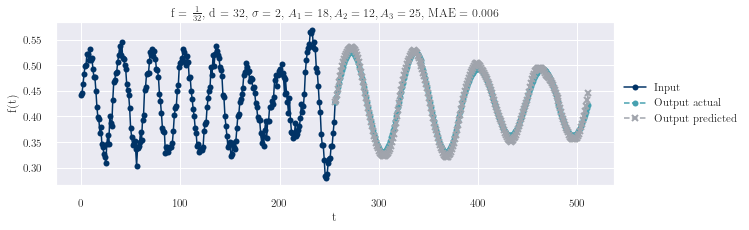

In [30]:

# Visualize
use_latex_font = False
viz = ModelPredictionVisualization(use_latex_font=False)
viz.subplots(nrows=1, ncols=1, figsize=(10, 3))
viz.plot(best_x_cut.reshape(1, -1), best_y_cut.reshape(1, -1), out_preds, pred_starts=[256, ])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.title(description)
viz.get_ax(0).set_ylabel("f(t)")
viz.get_ax(1).set_xlabel("t")
plt.savefig(base_dir_notebook+ "/figures/best_prediction_generalization.pdf", bbox_inches="tight")
viz.plt.show()

# visualize by mean

2021-11-11 00:19:55 Mischa-PC src.visualization[12604] INFO using latex font


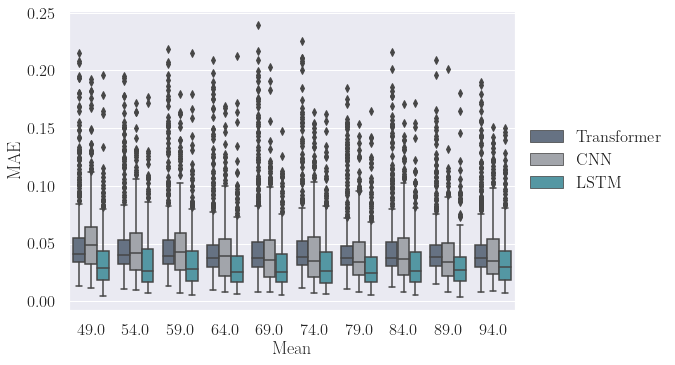

In [31]:
sorted(predictions["mean"].unique())

bin_boundaries = np.linspace(47, 97, 11)
bins = np.linspace(49, 94, 10)
for i in range(len(bin_boundaries) - 1):
    predictions.loc[(predictions["mean"] >= bin_boundaries[i]) & (predictions["mean"] < bin_boundaries[i + 1]), "mean_bin"] = bins[i]

viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
sns.boxplot(x="mean_bin", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.ylabel("MAE")
plt.xlabel("Mean")
plt.savefig(base_dir_notebook + "/figures/mae_different_mean_bins.pdf")

## Analyze Generalization Capabilities by looking at missing train delay length
Not that interesting. Maybe beccause of the data. Model can learn the first amplitude from the first
highest value independant of delay length. The second one I am not so sure about...

2021-11-11 00:19:56 Mischa-PC src.visualization[12604] INFO using latex font


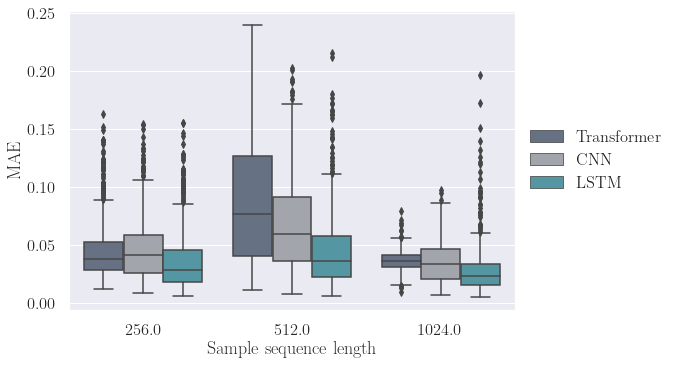

In [32]:
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
sns.boxplot(x="l", y="mae", hue="model", data=predictions[predictions["l"].isin([256, 512, 1024])], palette=palette_bp)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model"
plt.ylabel("MAE")
plt.xlabel("Sample sequence length")
plt.savefig(base_dir_notebook + "/figures/mae_different_sequence_lengths_all_models_generalization_only.pdf")

# Analyzing Optuna Studies
## Visualize all model performances

2021-11-11 00:19:57 Mischa-PC src.visualization[12604] INFO using latex font
2021-11-11 00:19:57 Mischa-PC matplotlib.legend[12604] WARNING No handles with labels found to put in legend.


<Figure size 576x396 with 0 Axes>

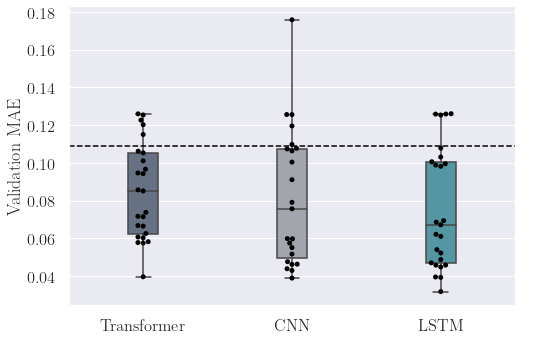

In [33]:
cnn_study_path = f"./models/{experiment_name}/cnn"
lstm_study_path = f"./models/{experiment_name}/lstm"
transformer_study_path= f"./models/{experiment_name}/transformer"

# load study summary (created by hyperparameter_tuning.py)
studies = {"cnn": cnn_study_path, "lstm": lstm_study_path, "transformer":transformer_study_path}
summaries = {}
models = {}
for model, path in studies.items():
    with open(os.path.join(path, "study_summary.yaml"), "r") as inp:
        try:
            summary = yaml.load(inp, Loader=yaml.BaseLoader)
        except yaml.YAMLError as e:
            print(e)
    summaries[model] = summary

MODEL_TO_MODEL_NAME = {"cnn": "CNN", "lstm":"LSTM", "transformer":"Transformer"}
train_values = []
for model in summaries.keys():
    storage = summaries[model]["storage_name"]
    study = optuna.load_study(study_name=summaries[model]["study_name"], storage=storage)
    for trial in study.trials:
        train_values.append({"train_value":trial.value, "model":MODEL_TO_MODEL_NAME[model]})


train_values = pd.DataFrame(train_values)

plt.clf()
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
sns.boxplot(x="model", y="train_value", order=["Transformer", "CNN", "LSTM"], data=train_values, palette=palette_bp, width=0.2)
sns.swarmplot(x="model", y="train_value", order=["Transformer", "CNN", "LSTM"], data=train_values, color="0")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
viz.get_ax(0).axhline(mean_predictor_mae, c="black", ls='--')
plt.ylabel("Validation MAE")
plt.xlabel("")
plt.savefig(base_dir_notebook + "/figures/validation_all_trials.pdf")

## Training time visualization

2021-11-11 00:19:59 Mischa-PC src.visualization[12604] INFO using latex font


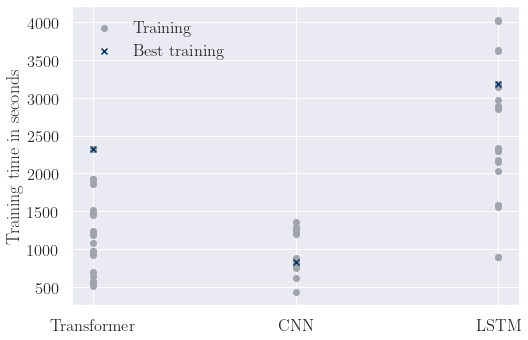

In [34]:
import optuna
from src.visualization.utils import FAU_BLUE, FAU_GREY

train_times = []
for model in [mn.lower() for mn in model_names]:
    storage = summaries[model]["storage_name"]
    study = optuna.load_study(study_name=summaries[model]["study_name"], storage=storage)
    for trial in study.trials:
        train_length = (trial.datetime_complete - trial.datetime_start).total_seconds()
        train_times.append({"train_length":train_length, "model":MODEL_TO_MODEL_NAME[model], "best":trial.number == study.best_trial.number})
train_times = pd.DataFrame(train_times)
best_times = train_times[train_times["best"] == True]

viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
plt.scatter(train_times["model"], train_times["train_length"], color=FAU_GREY, marker='o', label="Training")
plt.scatter(best_times["model"], best_times["train_length"], color=FAU_BLUE, marker='x', label="Best training")
viz.get_ax(0).set_ylabel("Training time in seconds")
plt.legend()
plt.savefig(base_dir_notebook + "/figures/training_times.pdf")

## Inference time visualization

In [35]:
n_runs = 5
viz = InferenceTimeVisualization(use_latex_font=True, font_scale=1.5)
viz.do_inference(n_runs=n_runs,
                 cnn_model=trained_models["cnn"]["model"],
                 cnn_trainer=cnn_trainer,
                 lstm_model=trained_models["lstm"]["model"],
                 lstm_trainer=lstm_trainer,
                 trafo_model=trained_models["transformer"]["model"],
                 trafo_trainer=tf_trainer,
                 dataloader=test_dataloader)

2021-11-11 00:19:59 Mischa-PC src.visualization[12604] INFO using latex font
C:\Users\Mischa\Anaconda3\envs\mtenv\lib\site-packages\pytorch_lightning\trainer\trainer.py:678: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
2021-11-11 00:19:59 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Mischa\Anaconda3\envs\mtenv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

2021-11-11 00:20:05 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:20:11 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:20:17 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:20:23 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:20:30 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:21:01 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:21:31 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:22:01 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:22:29 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:22:58 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:23:11 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:23:25 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:23:40 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:23:54 Mischa-PC pytorch_lightning.accelerators.gpu[12604] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

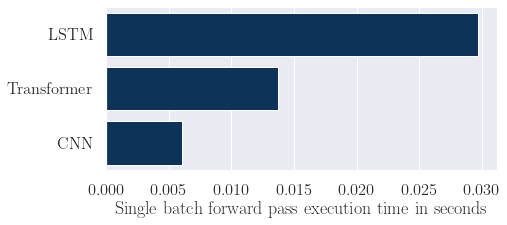

In [36]:
fig, axs = viz.subplots(1, 1, figsize=(7, 3))
viz.plot(axs[0, 0], palette=palette)
axs[0,0].set_xlabel("Single batch forward pass execution time in seconds")
axs[0,0].set_ylabel("")
plt.savefig(base_dir_notebook + f"/figures/single_batch_exec_{n_runs}_runs.pdf", bbox_inches="tight")

## Statistical tests


### Critical Difference Test from Fawaz paper applied to dataset

In [37]:
critical_difference_parameter = "l" # test only by sequence length
#pred_2 = predictions[predictions["d"].isin([0, 16, 32, 64, 128])]
mean_prediction_by_model = predictions.groupby(["model", critical_difference_parameter]).mean()
mean_prediction_by_model.head()
mean_prediction_by_model.reset_index(inplace=True) # resets multiindex
df_perf = mean_prediction_by_model[["model", critical_difference_parameter, "mae"]].rename(columns={"model":"classifier_name", critical_difference_parameter:"dataset_name", "mae":"accuracy"})

# reverse mae (for regression low values are good, for classification high values are good
df_perf["accuracy"] = df_perf["accuracy"].max() - df_perf["accuracy"]
df_perf.head(7)

,classifier_name,dataset_name,accuracy
0,CNN,128.0,0.046805
1,CNN,256.0,0.042166
2,CNN,512.0,0.020607
3,CNN,1024.0,0.052443
4,CNN,2048.0,0.054630
5,LSTM,128.0,0.054621
6,LSTM,256.0,0.051328


['CNN' 'LSTM' 'Transformer']
CNN            0.0
LSTM           5.0
Transformer    0.0
dtype: float64
Transformer    2.6
CNN            2.4
LSTM           1.0
dtype: float64
('CNN', 'LSTM', 0.0625, False)
('LSTM', 'Transformer', 0.0625, False)
('CNN', 'Transformer', 0.4375, False)
Index(['Transformer', 'CNN', 'LSTM'], dtype='object')
[0, 1, 2]


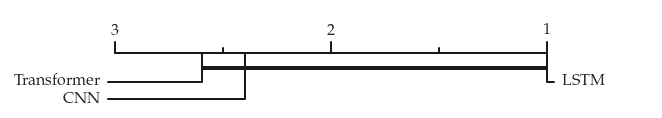

In [38]:
from src.visualization.critical_difference import draw_cd_diagram
draw_cd_diagram(df_perf=df_perf, output_path=os.path.join(base_dir_notebook, f"figures/critical_difference_test_for_{critical_difference_parameter}.pdf"))
### Critical Difference Test from Fawaz paper applied to dataset

### Critical difference test on all different characteristics

In [39]:
#pred_2 = predictions[predictions["d"].isin([0, 16, 32, 64, 128])]
mean_prediction_by_model = predictions.groupby(["model", "d", "l", "s", "f"]).mean()
mean_prediction_by_model.head()
mean_prediction_by_model.reset_index(inplace=True) # resets multiindex

In [40]:
df_perf = mean_prediction_by_model[["model", "d", "l", "s", "f", "mae"]].rename(columns={"model":"classifier_name", "mae":"accuracy"})
df_perf["dataset_name"] = ""
# populate dataset_names that indicates the different characteritics
dataset_names = []
for i in range(len(df_perf)):
    entry = df_perf.iloc[i]
    dataset_names.append(f"delay_{int(entry['d'])}_fre_{str(entry['f'])[2:]}_sigma_{int(entry['s'])}_len_{int(entry['l'])}")
df_perf["dataset_name"] = dataset_names
df_perf = df_perf[["classifier_name", "accuracy", "dataset_name"]]
df_perf.head(3)

,classifier_name,accuracy,dataset_name
0,CNN,0.034632,delay_0_fre_03125_sigma_2_len_128
1,CNN,0.038379,delay_0_fre_0625_sigma_2_len_128
2,CNN,0.035979,delay_0_fre_03125_sigma_5_len_128


['CNN' 'LSTM' 'Transformer']
CNN             0.0
LSTM           38.0
Transformer     2.0
dtype: float64
Transformer    2.625
CNN            2.325
LSTM           1.050
dtype: float64
('CNN', 'LSTM', 3.569388204466033e-08, True)
('LSTM', 'Transformer', 6.538886335515506e-08, True)
('CNN', 'Transformer', 0.009481948493125392, True)
Index(['Transformer', 'CNN', 'LSTM'], dtype='object')


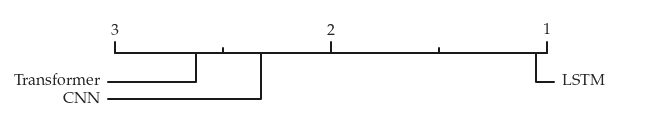

In [41]:
# reverse mae (for regression low values are good, for classification high values are good
df_perf["accuracy"] = df_perf["accuracy"].max() - df_perf["accuracy"]
df_perf.head(7)
from src.visualization.critical_difference import draw_cd_diagram
draw_cd_diagram(df_perf=df_perf, output_path=os.path.join(base_dir_notebook, f"figures/critical_difference_test_for_all_parameters.pdf"))

## When was lstm not the best?

In [42]:
for index, ds in df_perf.iterrows():
    if ds["classifier_name"] != "LSTM":
        continue

    ds_name = ds["dataset_name"]
    trafo_performance = df_perf[(df_perf["dataset_name"] == ds_name) & (df_perf["classifier_name"] == "Transformer")]
    cnn_performance = df_perf[(df_perf["dataset_name"] == ds_name) & (df_perf["classifier_name"] == "CNN")]
    if ds["accuracy"] < max(float(trafo_performance["accuracy"]), float(cnn_performance["accuracy"])):
        print(f"Trafo: {trafo_performance['accuracy']}, CNN: {cnn_performance['accuracy']}, LSTM:{ds['accuracy']}")
        print(ds_name)



Trafo: 100    0.055758
Name: accuracy, dtype: float32, CNN: 20    0.052124
Name: accuracy, dtype: float32, LSTM:0.05355224013328552
delay_32_fre_03125_sigma_2_len_128
Trafo: 102    0.054328
Name: accuracy, dtype: float32, CNN: 22    0.048471
Name: accuracy, dtype: float32, LSTM:0.05032114312052727
delay_32_fre_03125_sigma_5_len_128
